# Part 1: Preparing the dataset

Import libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    li

Instal LXML to read HTML

In [3]:
pip install lxml

     |████████████████████████████████| 5.8MB 22.2MB/s eta 0:00:01�█████████████▏     | 4.7MB 22.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Read the wiki page

In [4]:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
tables = pd.read_html(link, header=0)

In [5]:
Toronto = pd.DataFrame(tables[0])

Drop rows where Borough is 'Not assigned'

In [6]:
Toronto = Toronto[Toronto.Borough != 'Not assigned'].reset_index(drop=True)
Toronto = Toronto.rename(columns={'Neighbourhood': 'Neighborhood'})
Toronto.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


Assigne values to missing Neighbourhoods

In [7]:
l = len(Toronto)
for i in range(0,l):
    if Toronto.loc[i, 'Neighborhood'] == 'Not assigned':
        Toronto.loc[i, 'Neighborhood']=Toronto.loc[i, 'Borough']

Combining the Neighbourhoods with the same Postcode.

In [8]:
hl = pd.DataFrame()
hl['Postcode']=Toronto['Postcode'].unique()
hl['Borough'] = 'b'
hl['Neighborhood'] = 'n'
j = 0
for j in range (0, len(hl)):
    for i in range(0,l):
        if hl.loc[j, 'Postcode'] == Toronto.loc[i, 'Postcode']:
            hl.loc[j, 'Borough'] = Toronto.loc[i, 'Borough']
            if hl.loc[j, 'Neighborhood'] == 'n':
                 hl.loc[j, 'Neighborhood'] = Toronto.loc[i, 'Neighborhood']
            else:
                hl.loc[j, 'Neighborhood'] = hl.loc[j, 'Neighborhood'] + ', ' + Toronto.loc[i, 'Neighborhood']

In [9]:
Toronto = hl
Toronto.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [10]:
Toronto.shape

(103, 3)

# Part 2: Getting the postcode coordinates.

Note: I tried geocoder but couldn't even get one output...

In [ ]:
pip install geocoder

In [ ]:
import geocoder # import geocoder

# initialize your variable to None
lat_lng_coords = None
postal_code = 'M3A'

# loop until you get the coordinates
while(lat_lng_coords is None):
  g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
  lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

Extracting locations from the CSV file and merging with the Toronto dataframe.

In [11]:
postcodes = pd.read_csv('Geospatial_Coordinates.csv')
postcodes.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
Toronto = pd.merge(Toronto, postcodes, how='inner', left_on='Postcode', right_on='Postal Code')
Toronto = Toronto.drop(['Postal Code'], axis=1)
Toronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


# Part 3: Clustering

Obtaining coordinates of Toronto.

In [13]:
address = 'Toronto, CAN'

geolocator = Nominatim(user_agent="toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6607002, -79.3850889.


Let's see how all neighbourhoods look on the map.

In [14]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Setting Foursquare ID information.

In [15]:
CLIENT_ID = '1MZ4N3GP2BGLWSMOE43D5IOCNG4ZL1WP0QJA5HINAPE2FGY0' # your Foursquare ID
CLIENT_SECRET = 'F0ZAA2NOEFR1DETV52VEVT1QU04ROV1WO550KEW2AUSMPN05' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1MZ4N3GP2BGLWSMOE43D5IOCNG4ZL1WP0QJA5HINAPE2FGY0
CLIENT_SECRET:F0ZAA2NOEFR1DETV52VEVT1QU04ROV1WO550KEW2AUSMPN05


Function to obtain nearby venues from Foursquare.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Code to obtain 100 nearby venues in 500 radius from the neighborhood location.

In [17]:
limit = 100
radius = 500
toronto_venues = getNearbyVenues(names=Toronto['Neighborhood'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

Number of venues for each neighbourhood.

In [18]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",92,92,92,92,92,92
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",1,1,1,1,1,1
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",5,5,5,5,5,5
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Downsview North, Wilson Heights",9,9,9,9,9,9
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",20,20,20,20,20,20
Berczy Park,51,51,51,51,51,51


Grouping the venue categories by mean frequency of occurance.

In [19]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()


In [ ]:
toronto_onehot = toronto_onehot.groupby('Neighborhood').count().reset_index()
toronto_onehot.head(10)

In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [21]:
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",0.0,0.054348,0.0,0.0,0.054348,0.0,0.01087,0.032609,0.0,0.0,0.01087,0.032609,0.032609,0.021739,0.0,0.076087,0.0,0.0,0.01087,0.01087,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.021739,0.0,0.01087,0.01087,0.0,0.0,0.0,0.01087,0.0,0.0,0.021739,0.01087,0.0,0.01087,0.0,0.0,0.01087,0.021739,0.0,0.01087,0.0,0.0,0.01087,0.01087,0.0,0.0,0.0,0.021739,0.01087,0.0,0.0,0.01087,0.01087,0.076087,0.032609,0.065217,0.021739,0.0,0.01087,0.0,0.0,0.0,0.043478,0.032609,0.0,0.0,0.0,0.054348,0.0,0.032609,0.0,0.0
1,Agincourt,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.250000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.25000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.25000,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.250000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,1.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.2,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.20000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.400000,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.200000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,"Alderwood, Long Branch",0.0,

Function for computing SSE (Sum Square Error)

In [23]:
def compute_sse(n_clusters, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))

SSE computation....two options

In [24]:
import numpy as np
from numpy.linalg import norm
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
score1=[]
for i in range(0, 10):
    n_clusters = i+1
    kmeans_test=KMeans(n_clusters, random_state=0).fit(toronto_grouped_clustering)
    sse = compute_sse(n_clusters,toronto_grouped_clustering, kmeans_test.labels_, kmeans_test.cluster_centers_)
    score1.append(sse)

score1

[25.486017281912794,
 22.258899664402115,
 20.53720437367112,
 19.294717472784733,
 18.330932412277765,
 16.996708646695886,
 16.207296379212806,
 15.206683751410361,
 14.155808751807761,
 13.330833496303729]

In [25]:
score=[]
for i in range(0, 9):
    score.append(KMeans(n_clusters=i+1, random_state=0).fit(toronto_grouped_clustering).score(toronto_grouped_clustering))
    
score

[-25.486017281912794,
 -22.258899664402115,
 -20.537204373671123,
 -19.294717472784733,
 -18.330932412277765,
 -16.996708646695886,
 -16.207296379212806,
 -15.206683751410363,
 -14.155808751807763]

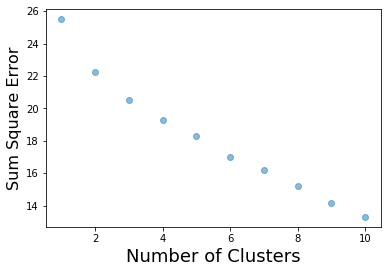

In [27]:
import matplotlib.pyplot as plt 
x = []
x.extend(range(1, 11))

plt.scatter(x, score1, alpha=0.5)
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Sum Square Error', fontsize=16)

plt.show()

Let's perform k-clustering using 3 clusters, since that is where we identify the "elbow" point.

In [28]:
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

Let's sort the venues in the neighbourhood by the most common venue. Here we create function and sort the data frame.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Café,Restaurant,Sandwich Place,American Restaurant,Thai Restaurant,Asian Restaurant,Steakhouse,Deli / Bodega,Burger Joint,Salad Place
1,Agincourt,Breakfast Spot,Chinese Restaurant,Latin American Restaurant,Sandwich Place,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Bakery,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Fried Chicken Joint,Japanese Restaurant,Sandwich Place,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
4,"Alderwood, Long Branch",Pizza Place,Burger Joint,Sandwich Place,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


Now, we will merge the sorted venues with original information about neighbourhoods locations and add the cluster number.

In [31]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Toronto
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

We need to drop some neighbourhoods since there are no information about their venues from Foursquare.

In [32]:
toronto_merged = toronto_merged.dropna(axis=0).reset_index(drop=True)
toronto_merged = toronto_merged.astype({'Cluster Labels': int})
print(toronto_merged.shape)
toronto_merged.head()

(92, 16)


,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,BBQ Joint,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Deli / Bodega,Portuguese Restaurant,French Restaurant,Pizza Place,Wings Joint,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,1,Café,Restaurant,Mexican Restaurant,Bakery,Breakfast Spot,Chinese Restaurant,Seafood Restaurant,Food Truck,Greek Restaurant,Italian Restaurant
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,1,Hot Dog Joint,BBQ Joint,Bakery,Vietnamese Restaurant,Argentinian Restaurant,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,1,Sushi Restaurant,Diner,Japanese Restaurant,Wings Joint,Sandwich Place,Middle Eastern Restaurant,Creperie,Chinese Restaurant,Persian Restaurant,Café


In [33]:
toronto_merged.groupby("Cluster Labels").count()

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
1,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76
2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [54]:
toronto_merged_hist.groupby('Cluster Labels')['1st Most Common Venue'].count()

Cluster Labels
0    10
1    76
2     6
Name: 1st Most Common Venue, dtype: int64

Lastly, we plot the neighbourhoods and colorcode them based on their cluster.

In [55]:
# create map
map_toronto_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_toronto_clusters)
       
map_toronto_clusters

# Part 4: Separate Cluster Examination

## Cluster 0

In [56]:
cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_0

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Etobicoke,0,Pizza Place,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
10,North York,0,Pizza Place,Asian Restaurant,Sushi Restaurant,Japanese Restaurant,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
30,Scarborough,0,Pizza Place,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
33,East York,0,Bakery,Pizza Place,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
53,Scarborough,0,Pizza Place,Café,Wings Joint,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
62,Etobicoke,0,Pizza Place,Chinese Restaurant,Sandwich Place,Middle Eastern Restaurant,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
64,North York,0,Pizza Place,Bakery,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
69,Etobicoke,0,Pizza Place,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
81,Etobicoke,0,Pizza Place,Fried Chicken Joint,Japanese Restaurant,Sandwich Place,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
85,Etobicoke,0,Pizza Place,Burger Joint,Sandwich Place,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


In [57]:
cluster_0.groupby('1st Most Common Venue').count()

,Borough,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1st Most Common Venue,,,,,,,,,,,
Bakery,1,1,1,1,1,1,1,1,1,1,1
Pizza Place,9,9,9,9,9,9,9,9,9,9,9


In [58]:
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_1.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1,Deli / Bodega,Portuguese Restaurant,French Restaurant,Pizza Place,Wings Joint,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
2,Downtown Toronto,1,Café,Restaurant,Mexican Restaurant,Bakery,Breakfast Spot,Chinese Restaurant,Seafood Restaurant,Food Truck,Greek Restaurant,Italian Restaurant
3,North York,1,Hot Dog Joint,BBQ Joint,Bakery,Vietnamese Restaurant,Argentinian Restaurant,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
4,Queen's Park,1,Sushi Restaurant,Diner,Japanese Restaurant,Wings Joint,Sandwich Place,Middle Eastern Restaurant,Creperie,Chinese Restaurant,Persian Restaurant,Café
7,North York,1,Caribbean Restaurant,Japanese Restaurant,Restaurant,Café,Wings Joint,Falafel Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [59]:
cluster_1.groupby('1st Most Common Venue').count()

,Borough,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1st Most Common Venue,,,,,,,,,,,
American Restaurant,2,2,2,2,2,2,2,2,2,2,2
Asian Restaurant,1,1,1,1,1,1,1,1,1,1,1
Bakery,3,3,3,3,3,3,3,3,3,3,3
Breakfast Spot,5,5,5,5,5,5,5,5,5,5,5
Burger Joint,1,1,1,1,1,1,1,1,1,1,1
Burrito Place,1,1,1,1,1,1,1,1,1,1,1
Cafeteria,1,1,1,1,1,1,1,1,1,1,1
Café,14,14,14,14,14,14,14,14,14,14,14
Caribbean Restaurant,1,1,1,1,1,1,1,1,1,1,1


In [60]:
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,BBQ Joint,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
6,Scarborough,2,Indian Restaurant,Fast Food Restaurant,Wings Joint,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
19,York,2,Fast Food Restaurant,Wings Joint,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
25,North York,2,Mediterranean Restaurant,Fast Food Restaurant,Wings Joint,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
52,York,2,Fast Food Restaurant,Fried Chicken Joint,Restaurant,Sandwich Place,Wings Joint,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
89,East Toronto,2,Fast Food Restaurant,Pizza Place,Restaurant,Burrito Place,Ethiopian Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


In [61]:
cluster_2.groupby('1st Most Common Venue').count()

,Borough,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1st Most Common Venue,,,,,,,,,,,
BBQ Joint,1,1,1,1,1,1,1,1,1,1,1
Fast Food Restaurant,3,3,3,3,3,3,3,3,3,3,3
Indian Restaurant,1,1,1,1,1,1,1,1,1,1,1
Mediterranean Restaurant,1,1,1,1,1,1,1,1,1,1,1
